In [5]:
%pip install --upgrade --no-deps tensorflow numpy pandas



  Using cached tensorflow-2.19.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
Using cached tensorflow-2.19.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (644.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 27.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 70.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf, numpy as np, pandas as pd

print("TensorFlow:", tf.__version__)
print("NumPy:     ", np.__version__)
print("pandas:    ", pd.__version__)


2025-05-20 22:41:49.032464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747780909.062617   10751 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747780909.073081   10751 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747780909.094749   10751 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747780909.094786   10751 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747780909.094789   10751 computation_placer.cc:177] computation placer alr

TensorFlow: 2.19.0
NumPy:      2.2.6
pandas:     2.2.3


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1) Correct path to your train folder
dataset_path = 'chest_xray/chest_xray/train'

# 2) Prepare data generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_gen = datagen.flow_from_directory(
    dataset_path, target_size=(150,150), batch_size=16,
    class_mode='binary', subset='training'
)
val_gen = datagen.flow_from_directory(
    dataset_path, target_size=(150,150), batch_size=16,
    class_mode='binary', subset='validation'
)

# 3) Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

# 4) Compile & train
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_gen, validation_data=val_gen, epochs=3)

# 5) Save your model
model.save("pneumonia_classifier.h5")


Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Epoch 1/3
261/261 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.8440 - loss: 0.3771 - val_accuracy: 0.9463 - val_loss: 0.1414
Epoch 2/3
261/261 ━━━━━━━━━━━━━━━━━━━━ 245s 939ms/step - accuracy: 0.9683 - loss: 0.0862 - val_accuracy: 0.9444 - val_loss: 0.1584
Epoch 3/3
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.9830 - loss: 0.0560

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-20 22:42:18.530512: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    'chest_xray/chest_xray/test',
    target_size=(150,150),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

loss, acc = model.evaluate(test_gen)
print(f"Test accuracy: {acc*100:.2f}%")


Found 624 images belonging to 2 classes.
39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 576ms/step - accuracy: 0.4841 - loss: 2.1002
Test accuracy: 73.24%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


(np.float64(-0.5), np.float64(149.5), np.float64(149.5), np.float64(-0.5))

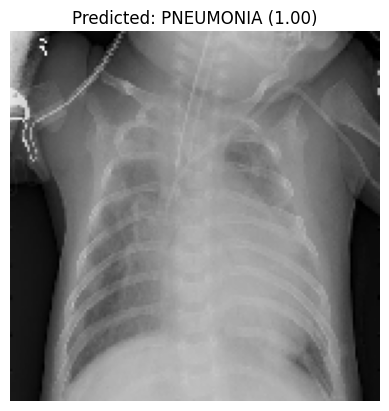

In [4]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# point to a test image
img_path = 'chest_xray/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg'

img = image.load_img(img_path, target_size=(150,150))
x   = image.img_to_array(img)/255.0
x   = np.expand_dims(x,0)

pred = model.predict(x)[0][0]
label = "PNEUMONIA" if pred > 0.5 else "NORMAL"

plt.imshow(img, cmap='gray')
plt.title(f"Predicted: {label} ({pred:.2f})")
plt.axis('off')


In [7]:
import os
import random
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image

# 1) Collect all test images with their true labels
test_dir = 'chest_xray/chest_xray/test'
classes = ['NORMAL', 'PNEUMONIA']
all_images = []
for cls in classes:
    cls_dir = os.path.join(test_dir, cls)
    for fname in os.listdir(cls_dir):
        if fname.lower().endswith(('.jpeg','.jpg','.png')):
            all_images.append((os.path.join(cls_dir, fname), cls))

# 2) Sample 20 at random
random.seed(123)
sampled = random.sample(all_images, 20)

# 3) Predict and record results
rows = []
for img_path, true_label in sampled:
    img = image.load_img(img_path, target_size=(150,150))
    x   = image.img_to_array(img) / 255.0
    x   = np.expand_dims(x, 0)
    score = float(model.predict(x)[0][0])
    pred_label = "PNEUMONIA" if score > 0.5 else "NORMAL"
    rows.append({
        'Image Path': os.path.basename(img_path),
        'True Label': true_label,
        'Predicted': pred_label,
        'Score': round(score, 3)
    })

# 4) Show as a DataFrame
df = pd.DataFrame(rows)
df


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

,Image Path,True Label,Predicted,Score
0,IM-0086-0001.jpeg,NORMAL,NORMAL,0.010
1,person113_bacteria_541.jpeg,PNEUMONIA,PNEUMONIA,1.000
2,NORMAL2-IM-0073-0001.jpeg,NORMAL,PNEUMONIA,0.712
3,person161_bacteria_762.jpeg,PNEUMONIA,PNEUMONIA,0.998
4,person112_bacteria_539.jpeg,PNEUMONIA,PNEUMONIA,1.000
5,NORMAL2-IM-0135-0001.jpeg,NORMAL,NORMAL,0.162
6,IM-0063-0001.jpeg,NORMAL,PNEUMONIA,0.968
7,person152_bacteria_724.jpeg,PNEUMONIA,PNEUMONIA,0.939
8,person69_virus_129.jpeg,PNEUMONIA,PNEUMONIA,1.000
9,person81_bacteria_397.jpeg,PNEUMONIA,PNEUMONIA,0.998


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


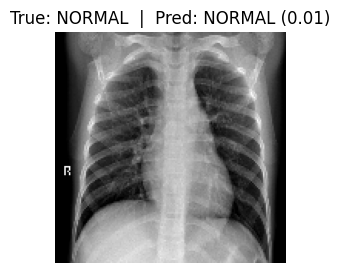

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


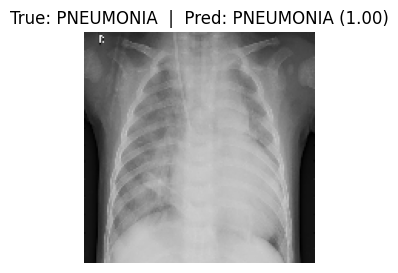

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


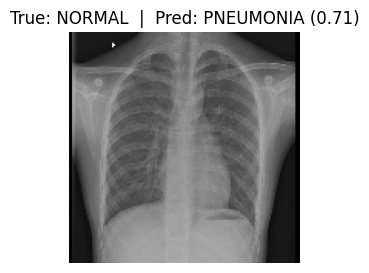

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


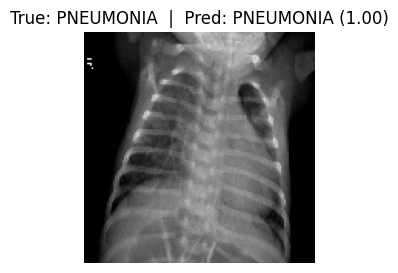

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


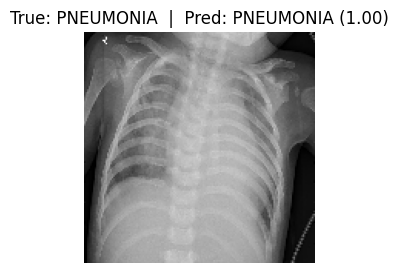

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


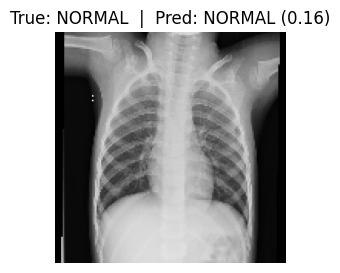

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


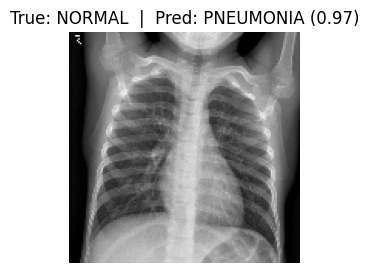

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


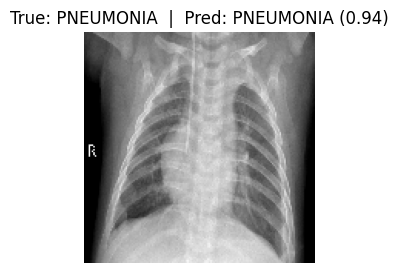

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


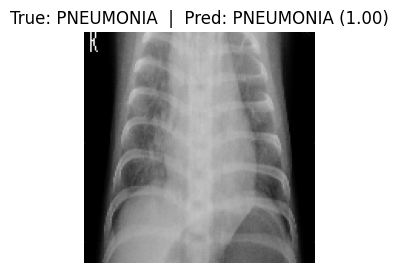

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


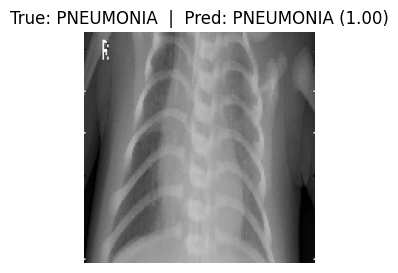

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


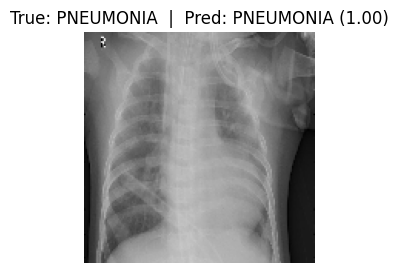

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


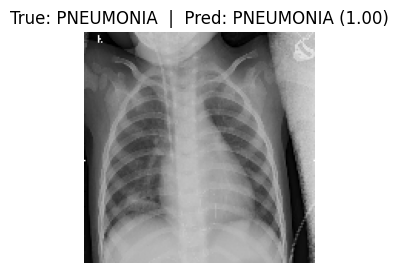

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


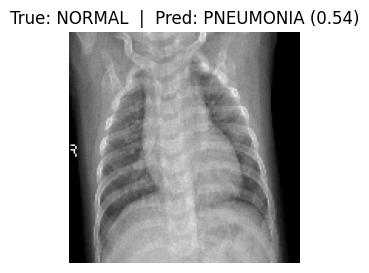

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


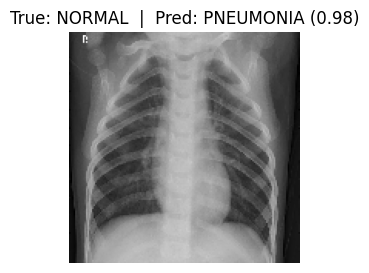

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


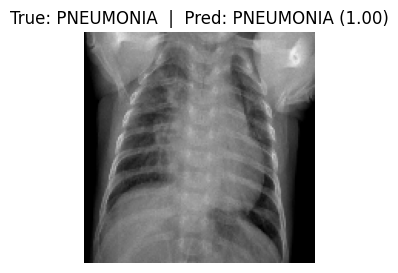

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


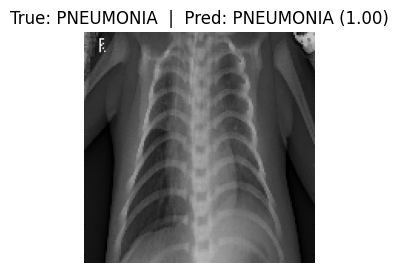

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


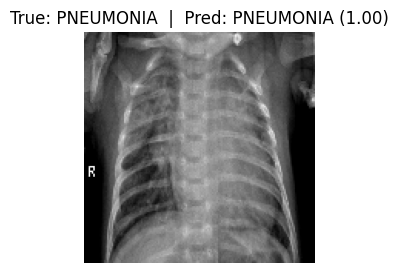

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


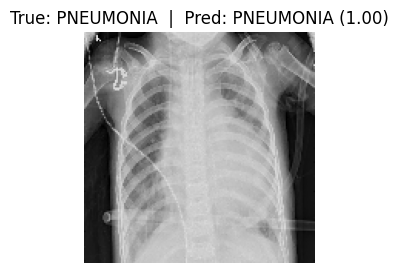

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


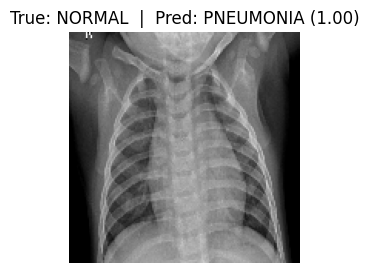

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


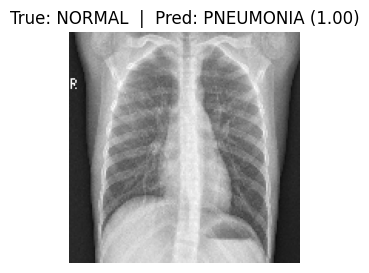

In [8]:
import os
import random
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# 1) Collect all test images with true labels
test_dir = 'chest_xray/chest_xray/test'
classes = ['NORMAL', 'PNEUMONIA']
all_images = []
for cls in classes:
    cls_dir = os.path.join(test_dir, cls)
    for fname in os.listdir(cls_dir):
        if fname.lower().endswith(('.jpeg', '.jpg', '.png')):
            all_images.append((os.path.join(cls_dir, fname), cls))

# 2) Sample 20 at random
random.seed(123)
sampled = random.sample(all_images, 20)

# 3) Loop: predict and display each
for img_path, true_label in sampled:
    # Load & preprocess
    img = image.load_img(img_path, target_size=(150,150))
    x   = image.img_to_array(img) / 255.0
    x   = np.expand_dims(x, 0)

    # Predict
    score = float(model.predict(x)[0][0])
    pred_label = "PNEUMONIA" if score > 0.5 else "NORMAL"

    # Display
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.title(f"True: {true_label}  |  Pred: {pred_label} ({score:.2f})")
    plt.axis('off')
    plt.show()
